<a href="https://colab.research.google.com/github/soerenml/p1/blob/master/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for time series

Source: `Nielsen (2019), pp. 289-342`

**General introduction:**

Deep learning models relax some of the statistical assumptions we normallty have to deal with when using classical methods like ARIMA.

**Most important:**
+ Stationarity is no longer required.
+ We do not need to define parameters like seasonality.

**Beware:**

Even if deep learning models seem to very robust in terms of data requirements, we **should** do some processing like:
+ Standardization
+ TODO: name other techniques




In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


# Load and prepare data

## Download data

In [2]:
%%capture
pip install yfinance

In [9]:
def get_stock_data(stocks):
  """
  Function to import stock data.
  Args:
    stocks: list of ticker symbols to be downloaded.
  """
  tickerData = yf.Ticker(stocks)
  td = tickerData.history(
      period='1d',
      start='2000-1-1',
      end='2020-1-25'  
  )   
  return td

df = get_stock_data('SPY')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,99.717449,99.717449,96.774691,97.825676,8164300,0.0,0
2000-01-04,96.543491,96.900826,93.926538,94.000107,8089800,0.0,0
2000-01-05,94.126219,95.198224,92.318525,94.168259,12177900,0.0,0
2000-01-06,93.916044,95.177226,92.654861,92.654861,6227200,0.0,0
2000-01-07,94.378468,98.035896,94.210310,98.035896,8066500,0.0,0
...,...,...,...,...,...,...,...
2020-01-17,324.556166,325.025809,323.724466,324.800781,95846000,0.0,0
2020-01-21,323.773385,325.025817,323.695121,324.164764,77742400,0.0,0
2020-01-22,325.084468,325.779198,324.037535,324.203857,48914900,0.0,0


## Plot data

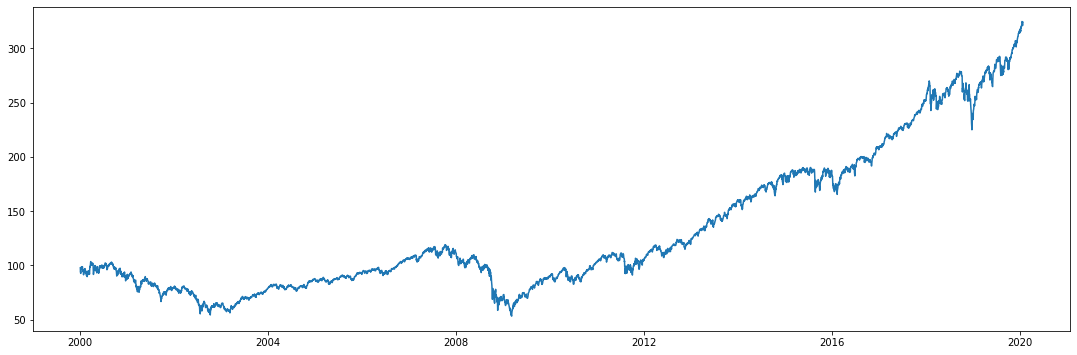

In [23]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_axes([0.1,0.2,0.8,0.9])
ax.plot(df['Close'])

In [24]:
df = df[["Open", "Volume"]]
df.columns = ["Open", "Volume"] 
df.head()

,Open,Volume
Date,,
2000-01-03,99.717449,8164300
2000-01-04,96.543491,8089800
2000-01-05,94.126219,12177900
2000-01-06,93.916044,6227200
2000-01-07,94.378468,8066500


### Create date sets

In [25]:
def create_datasets(train_size, test_size):
  """
  Args:
    train_size: obs. training set (%)
    test_size: obs. validation set (%)
  """
  # Create sets
  n = len(df)
  train_df = df[0:int(n*train_size)]
  val_df = df[int(n*train_size):int(n*test_size)]
  test_df = df[int(n*test_size):]
  
  # Extract metadata
  column_indices = {name: i for i, name in enumerate(df.columns)}
  num_features = df.shape[1]
  
  return column_indices, n, train_df, val_df, test_df, num_features

column_indices, n, train_df, val_df, test_df, num_features = create_datasets(0.7, 0.9)

print(column_indices)

{'Open': 0, 'Volume': 1}


# Create windows

[Example](https://www.tensorflow.org/tutorials/structured_data/images/split_window.png)



In [26]:
class WindowGenerator():
  def __init__(
      self,
      input_width,
      label_width,
      shift,
      train_df=train_df,
      val_df=val_df,
      test_df=test_df,
      label_columns=None):
    
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    # TODO: understand this part.
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Store window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)

    # Return evenly spaced intervals.
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}\n',
        f'Input indices: {self.input_indices}\n',
        f'Label indices: {self.label_indices}\n',
        f'Label column name(s): {self.label_columns}\n',
        f'Column indices: {self.column_indices}'])


  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


  def make_dataset(self, data):
    #data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window) # split_window() is used as a mapping function.
    return ds


  def plot(self, model=None, plot_col='Open', max_subplots=3):
    """
    Funtion to plot time series.
    """
    inputs, labels = self.example
    plt.figure(figsize=(20, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
       plt.legend()

    plt.xlabel('Time')

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Train final model

In [27]:
wide_window = WindowGenerator(
    input_width=7,
    label_width=7,
    shift=1,
    label_columns=['Open'])

wide_window

Total window size: 8

Input indices: [0 1 2 3 4 5 6]

Label indices: [1 2 3 4 5 6 7]

Label column name(s): ['Open']

Column indices: {'Open': 0, 'Volume': 1}

In [28]:
print(wide_window.train.element_spec)

w1 = wide_window.train
[(features, label)] = w1.take(1)
print(features[0,:,:])

(TensorSpec(shape=(None, 7, 2), dtype=tf.float64, name=None), TensorSpec(shape=(None, 7, 1), dtype=tf.float64, name=None))
tf.Tensor(
[[8.33698008e+01 3.82924800e+08]
 [8.33374668e+01 2.33385200e+08]
 [8.37658499e+01 2.56935300e+08]
 [8.33536382e+01 2.53769400e+08]
 [8.64815263e+01 2.10842100e+08]
 [8.65866143e+01 1.44999900e+08]
 [8.69664602e+01 1.31283600e+08]], shape=(7, 2), dtype=float64)


In [29]:
# Check tensor dimension input data.
wide_window.train

<MapDataset shapes: ((None, 7, 2), (None, 7, 1)), types: (tf.float64, tf.float64)>

In [33]:
inputs = tf.keras.Input(shape=(7, 2))
ls_1 = tf.keras.layers.LSTM(32, return_sequences=True)(inputs)
ls_2 = tf.keras.layers.LSTM(32, return_sequences=True)(ls_1)
outputs = tf.keras.layers.Dense(units=1)(ls_2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lstm")
model.summary()
inputs

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 2)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 32)             4480      
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 1)              33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


<KerasTensor: shape=(None, 7, 2) dtype=float32 (created by layer 'input_2')>

In [34]:
def compile_and_fit(model, window):

  model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(
      window.train,
      validation_data=window.val,
      epochs=10)
  
  
  return history

In [35]:
history = compile_and_fit(model, wide_window)

Epoch 1/10
111/111 [==============================] - 6s 21ms/step - loss: 8481.0381 - mean_absolute_error: 89.7171 - val_loss: 34930.5391 - val_mean_absolute_error: 185.3344
Epoch 2/10
111/111 [==============================] - 1s 13ms/step - loss: 7277.6436 - mean_absolute_error: 82.7365 - val_loss: 33156.6953 - val_mean_absolute_error: 180.4801
Epoch 3/10
111/111 [==============================] - 2s 14ms/step - loss: 6570.8765 - mean_absolute_error: 78.3444 - val_loss: 31698.2363 - val_mean_absolute_error: 176.3910
Epoch 4/10
111/111 [==============================] - 1s 13ms/step - loss: 5969.0249 - mean_absolute_error: 74.3992 - val_loss: 30366.6621 - val_mean_absolute_error: 172.5739
Epoch 5/10
111/111 [==============================] - 2s 14ms/step - loss: 5431.8076 - mean_absolute_error: 70.6953 - val_loss: 29134.2539 - val_mean_absolute_error: 168.9643
Epoch 6/10
111/111 [==============================] - 2s 14ms/step - loss: 4944.8076 - mean_absolute_error: 67.1603 - val_los